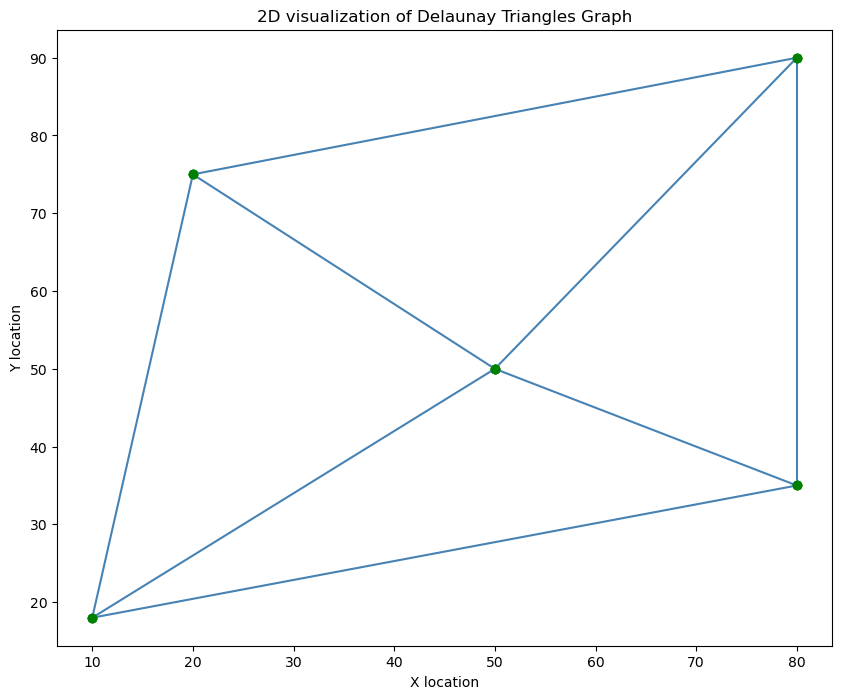

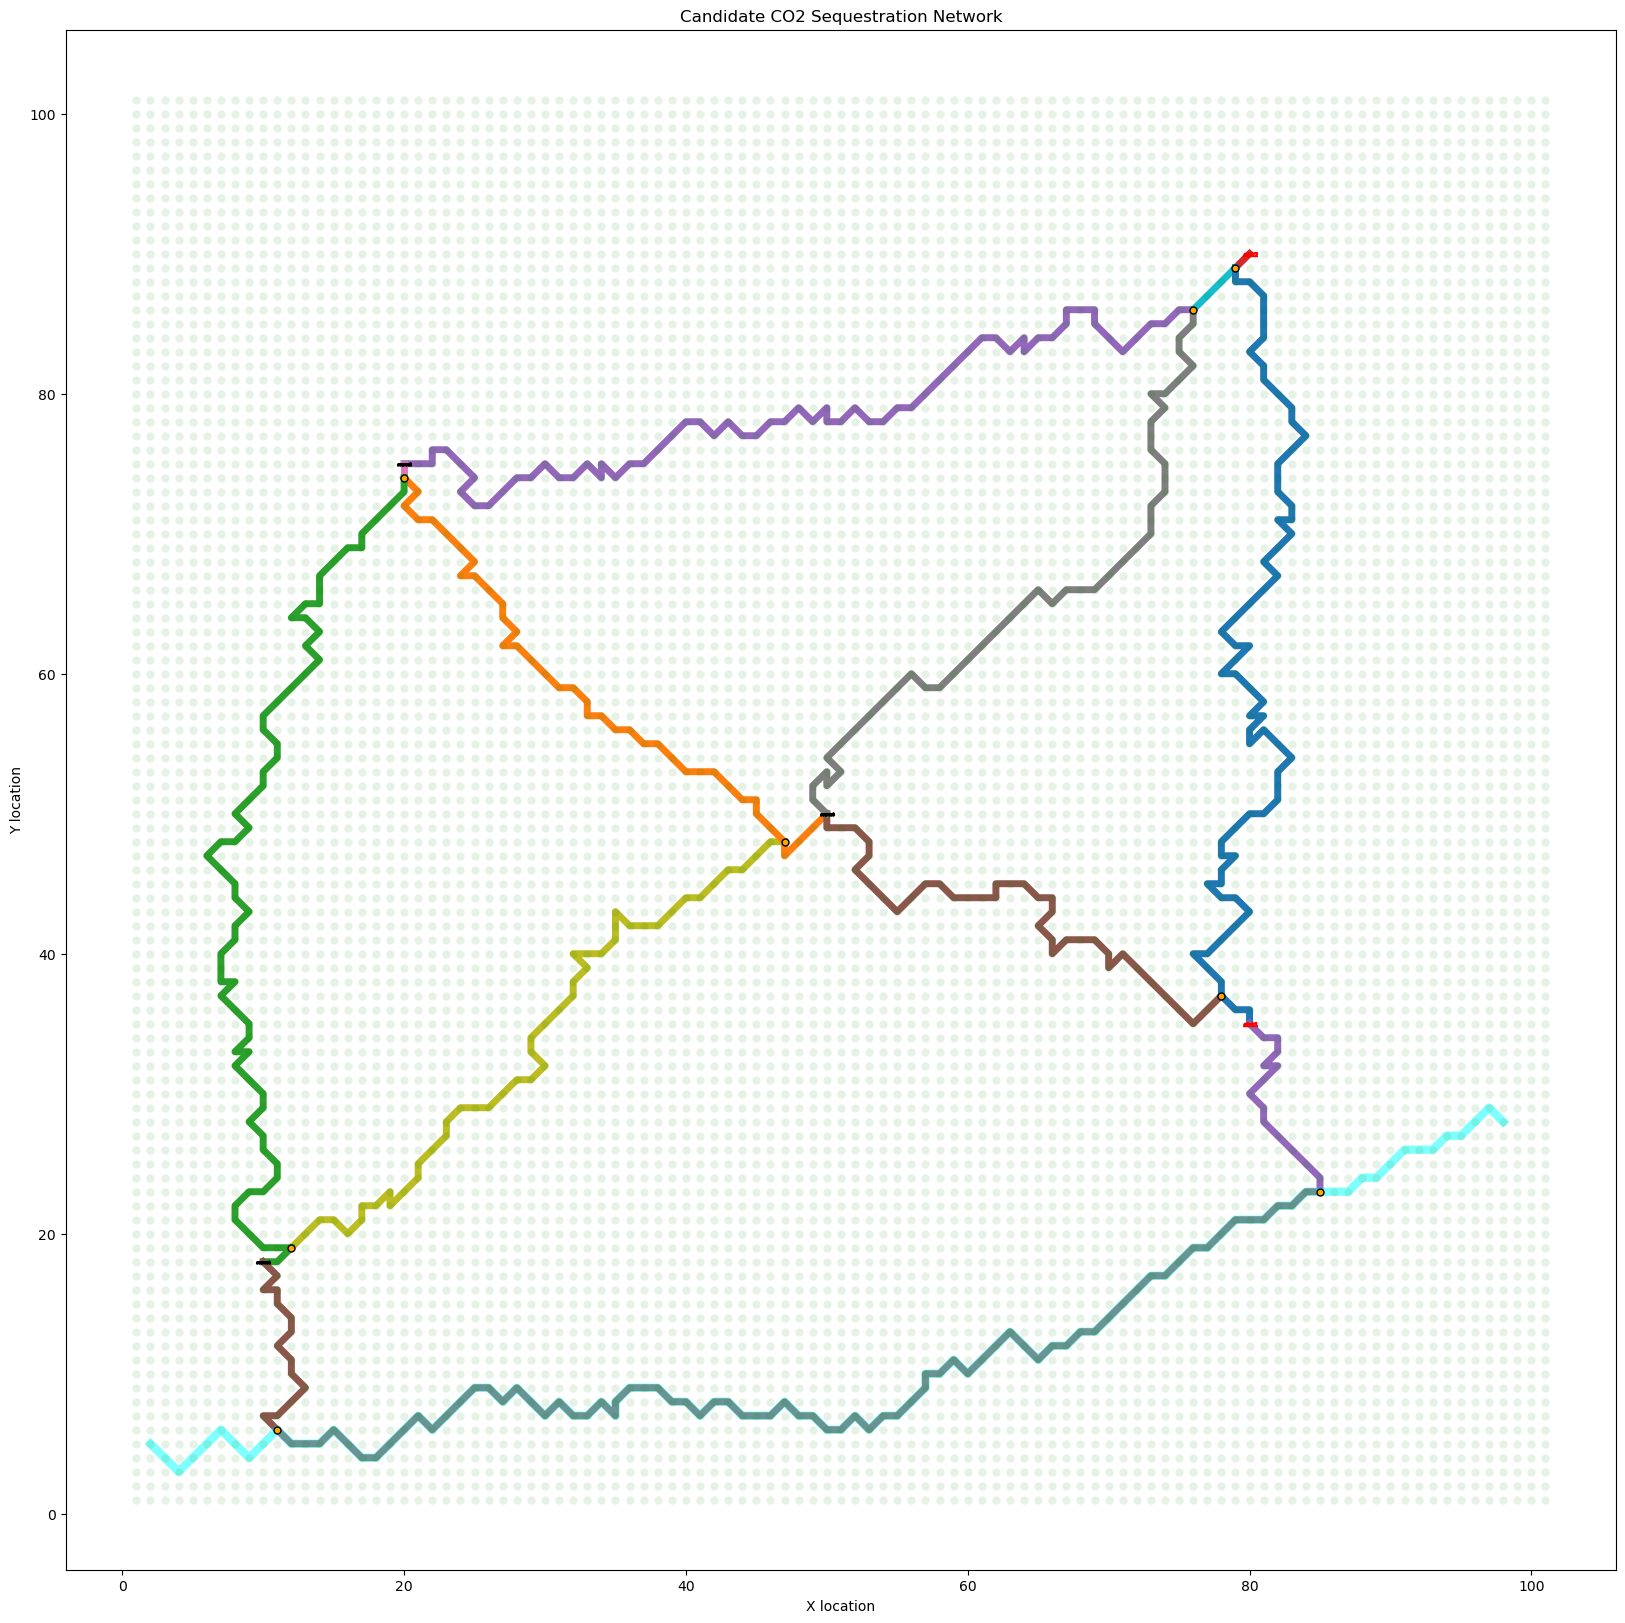

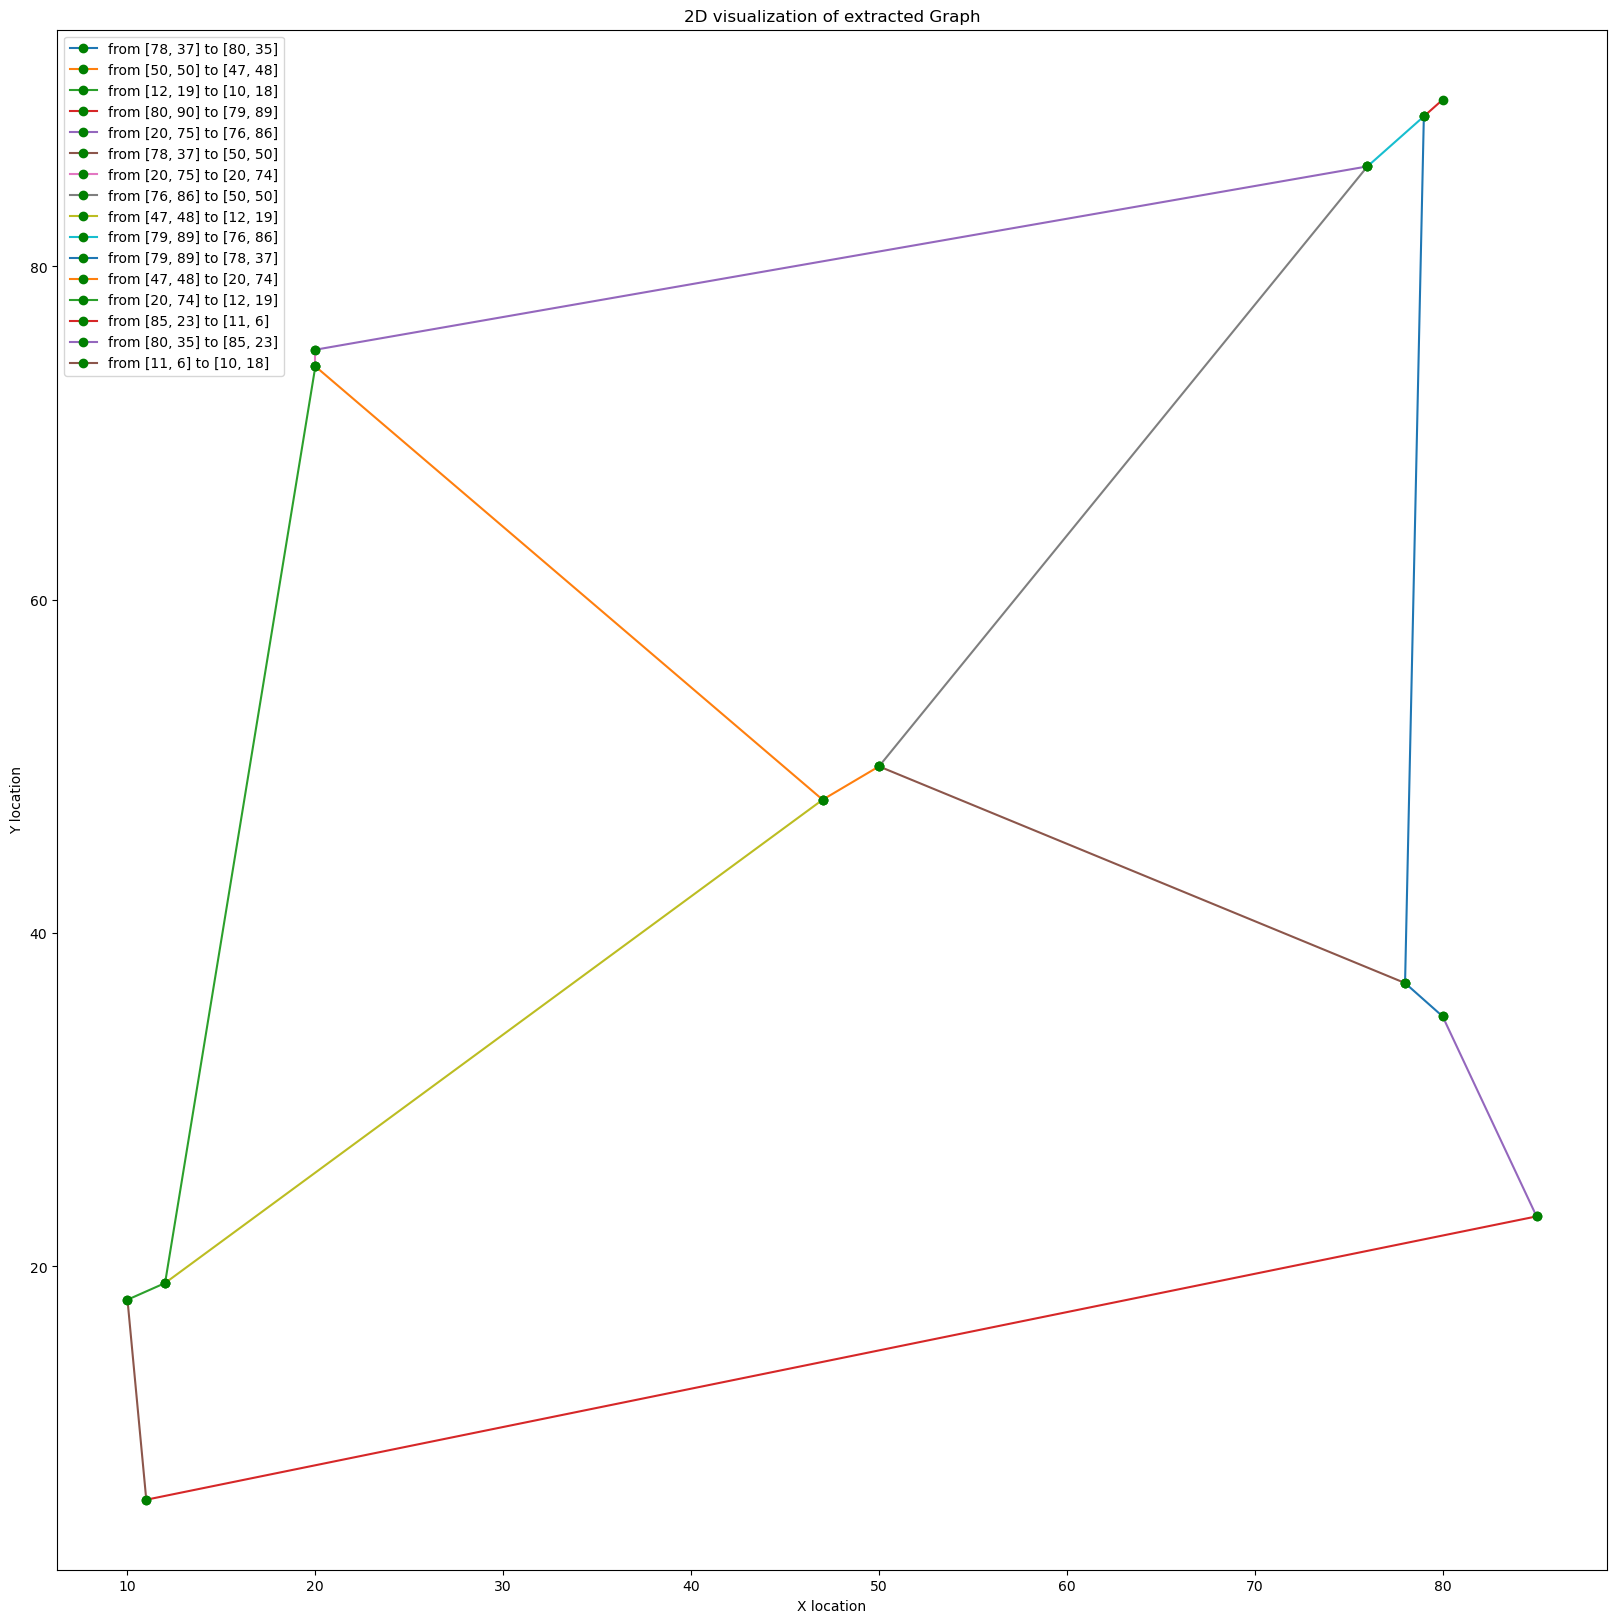

['source 1', 'source 2', 'source 3', 'sink 1', 'sink 2', 'TS1', 'TS2', 'TS3', 'TS4', 'TS5', 'TS6', 'TS7', 'TS8']
[('TS1', 'sink 1'), ('sink 1', 'TS1'), ('source 3', 'TS2'), ('TS2', 'source 3'), ('TS3', 'source 1'), ('source 1', 'TS3'), ('sink 2', 'TS4'), ('TS4', 'sink 2'), ('source 2', 'TS5'), ('TS5', 'source 2'), ('TS1', 'source 3'), ('source 3', 'TS1'), ('source 2', 'TS6'), ('TS6', 'source 2'), ('TS5', 'source 3'), ('source 3', 'TS5'), ('TS2', 'TS3'), ('TS3', 'TS2'), ('TS4', 'TS5'), ('TS5', 'TS4'), ('TS4', 'TS1'), ('TS1', 'TS4'), ('TS2', 'TS6'), ('TS6', 'TS2'), ('TS6', 'TS3'), ('TS3', 'TS6'), ('TS7', 'TS8'), ('TS8', 'TS7'), ('sink 1', 'TS7'), ('TS7', 'sink 1'), ('TS8', 'source 1'), ('source 1', 'TS8')]
{('TS1', 'sink 1'): 29.880000000000003, ('sink 1', 'TS1'): 29.880000000000003, ('source 3', 'TS2'): 20.78, ('TS2', 'source 3'): 20.78, ('TS3', 'source 1'): 27.28, ('source 1', 'TS3'): 27.28, ('sink 2', 'TS4'): 28.11, ('TS4', 'sink 2'): 28.11, ('source 2', 'TS5'): 578.2199999999999, ('T

In [121]:
import time
import pandas as pd
import numpy as np
from dummyCostSurface import dummyCostSurface
from networkDelanunay import networkDelanunay
from networkx import DiGraph
import networkx as nx
from matplotlib import rcParams
import matplotlib.pyplot as plt
from itertools import combinations

%matplotlib inline
rcParams['figure.figsize'] = 10, 8

class candidateNetwork(DiGraph):
    def __init__(self, n=100):
        super().__init__()
        self.n = n
        self.existingPath = {}
        self.existingPathVertices = {}
        self.existingPathType = {}
        self.sources = {}
        self.sinks = {}
        self.spathsCost = {}
        self.spaths = {}
        self.assetsXY = {}
        self.assetsPT = {}
        self.assetNameFromPT = {}
        self.assetNameFromXY = {}
        self.initial_pipe_spaths = {}
        
        
    
    def initialize_dummy_cost_surface(self):
        C = dummyCostSurface(self.n, lowcost=1, highcost=60, ctype='float')
        C.generate_cost_surface()
        
        self.add_nodes_from(C.get_vertices())
        self.add_edges_from(C.get_ebunch())
        
    def add_vertices_from_list(self, vertices):
        self.add_nodes_from(vertices)
        
    def add_edges_from_list(self, edgelist):
        self.add_weighted_edges_from(edgelist)
        
        
    def import_pipeline(self, input_dir, pathname, flowtype='bidirectional'):
        pipeline = pd.read_excel(input_dir)
        pipe_nodes = []
        start_nodes = pipeline['Start'].values
        end_nodes = pipeline['End'].values
        
        for i in range(len(pipeline)):
            pipe_nodes.append((start_nodes[i], end_nodes[i]))
            
        self.add_existing_zero_cost_path(pathname, pipe_nodes, flowtype)
        self.existingPathType[pathname] = flowtype
        
    def add_existing_zero_cost_path(self, pathname, path_nodes, flowtype):
        existingPathVertices = {}
        np = 0
        for nodepair in path_nodes:
            self.edges[nodepair[0], nodepair[1]]['weight'] = 0
            if flowtype == 'bidirectional':
                self.edges[nodepair[1], nodepair[0]]['weight'] = 0
                self.edges[nodepair[1], nodepair[0]]['weight'] = 0
            elif flowtype == 'unidirectional':
                self.edges[nodepair[1], nodepair[0]]['weight'] = 0
                self.edges[nodepair[1], nodepair[0]]['weight'] = 999999999
            
            if pathname in self.existingPath:
                self.existingPath[pathname].append(nodepair)
            else:
                self.existingPath[pathname] = [nodepair]
            
            if pathname in existingPathVertices:
                existingPathVertices[pathname].append(nodepair[0])
            else:
                existingPathVertices[pathname] = [nodepair[0]]
                
            np = nodepair[1]
        
        existingPathVertices[pathname].append(np)
        self.existingPathVertices = existingPathVertices
        
    def get_existing_zero_cost_path(self):
        return self.existingPath
    
    def get_existing_zero_cost_path_vertices(self):
        return self.existingPathVertices
    
    def get_initial_pipe_spaths(self):
        return self.initial_pipe_spaths
    
    def enforce_pipeline_tie_point(self, pathname, point1=None, point2=None, exclusion=False, etype='before'):
        #convert x,y to points on the graph
        if point1:
            point1 = self.D.get_point_from_xy(point1[0], point1[1])
        if point2:
            point2 = self.D.get_point_from_xy(point2[0], point2[1])
        
        
        #case 1: 2 tie in points with all exclusion
        if point1 and point2 and (not exclusion):
            for edge in self.edges:
                #in
                if (edge[1] in self.existingPathVertices[pathname]) and (edge[0] not in self.existingPathVertices[pathname]) \
                    and (edge[1] != point1) and (edge[1] != point2):
                    self.edges[edge]['weight'] = 999999999
                    
                #out
                if (edge[0] in self.existingPathVertices[pathname]) and (edge[1] not in self.existingPathVertices[pathname]) \
                    and (edge[0] != point1) and (edge[0] != point2):
                    self.edges[edge]['weight'] = 999999999
                
            
        #case 2: 2 tie in points with exclusion at ends
        elif point1 and point2 and exclusion:
            #get all the vertices before and after point 1 and 2
            pathvertices = self.existingPathVertices[pathname].copy()
            minidx, maxidx = map(pathvertices.index, (point1, point2))
            minidx, maxidx = min(minidx, maxidx), max(minidx, maxidx)
            not_excluded = pathvertices[minidx:maxidx+1]
            exclusion_list = [i for i in pathvertices if i not in not_excluded]
            
            for edge in self.edges:
                #in
                if (edge[1] in exclusion_list) and (edge[0] not in pathvertices) \
                    and (edge[1] != point1) and (edge[1] != point2):
                    self.edges[edge]['weight'] = 999999999
                
                #out
                if (edge[0] in exclusion_list) and (edge[1] not in pathvertices) \
                    and (edge[0] != point1) and (edge[0] != point2):
                    self.edges[edge]['weight'] = 999999999
                    
        
        else:
            #case 3 single point with all exclusion but source/sink
            if (point1 or point2) and (not exclusion):
                point = point1 or point2
                pathvertices = self.existingPathVertices[pathname].copy()
                if pathvertices[0] > pathvertices[-1]: #make the path always read from left to right
                    pathvertices.reverse()
                if etype == 'before':
                    exclusion_list = pathvertices[:-1] #means source/sink is at end of path
                else:
                    exclusion_list = pathvertices[1:] #means source/sink is at begining of path
                
                for edge in self.edges:
                    #in
                    if (edge[1] in exclusion_list) and (edge[0] not in pathvertices) \
                        and (edge[1] != point):
                        self.edges[edge]['weight'] = 999999999
                    #out    
                    if (edge[0] in exclusion_list) and (edge[1] not in pathvertices) \
                        and (edge[0] != point):
                        self.edges[edge]['weight'] = 999999999
                
            
            #case 4 single point with before or after exclusion on one end
            elif (point1 or point2) and exclusion:
                point = point1 or point2
                pathvertices = self.existingPathVertices[pathname].copy()
                if pathvertices[0] > pathvertices[-1]: #make the path always read from left to right
                    pathvertices.reverse()
                if etype == 'before':
                    exclusion_list = pathvertices[:pathvertices.index(point)]
                else:
                    exclusion_list = pathvertices[pathvertices.index(point)+1:]
                    
                for edge in self.edges:
                    #in
                    if (edge[1] in exclusion_list) and (edge[0] not in pathvertices) \
                        and (edge[1] != point):
                        self.edges[edge]['weight'] = 999999999
                    
                    #out
                    if (edge[0] in exclusion_list) and (edge[1] not in pathvertices) \
                        and (edge[0] != point):
                        self.edges[edge]['weight'] = 999999999
                

    
    def enforce_no_pipeline_diagonal_Xover(self):
        for pathname in self.existingPath.keys():
            for nodepair in self.existingPath[pathname]:
                if abs(nodepair[0] - nodepair[1]) == self.n+2:
                    lower_diag = min(nodepair) + 1
                    upper_diag = max(nodepair) - 1
                    
                    self.edges[(lower_diag, upper_diag)]['weight'] = 999999999
                    self.edges[(upper_diag, lower_diag)]['weight'] = 999999999
                    
                elif abs(nodepair[0] - nodepair[1]) == self.n:
                    lower_diag = min(nodepair) - 1
                    upper_diag = max(nodepair) + 1
                    
                    self.edges[(lower_diag, upper_diag)]['weight'] = 999999999
                    self.edges[(upper_diag, lower_diag)]['weight'] = 999999999
        return
    
    def enforce_no_path_diagonal_Xover(self, path_tup):
        for nodepair in path_tup:
            if abs(nodepair[0] - nodepair[1]) == self.n+2:
                lower_diag = min(nodepair) + 1
                upper_diag = max(nodepair) - 1
                    
                self.edges[(lower_diag, upper_diag)]['weight'] = 999999999
                self.edges[(upper_diag, lower_diag)]['weight'] = 999999999
                    
            elif abs(nodepair[0] - nodepair[1]) == self.n:
                lower_diag = min(nodepair) - 1
                upper_diag = max(nodepair) + 1
                    
                self.edges[(lower_diag, upper_diag)]['weight'] = 999999999
                self.edges[(upper_diag, lower_diag)]['weight'] = 999999999
        return
    
    
    def add_sources(self, sourcelist):
        for source in sourcelist:
            self.sources[source[0]] = [source[1], source[2]]
            self.assetsXY[source[0]] = [source[1], source[2]]
            
    def add_sinks(self, sinklist):
        for sink in sinklist:
            self.sinks[sink[0]] = [sink[1], sink[2]]
            self.assetsXY[sink[0]] = [sink[1], sink[2]]
            
    def _generate_assetsPT(self):
        for key in self.assetsXY.keys():
            self.assetsPT[key] = self.D.get_point_from_xy(self.assetsXY[key][0], self.assetsXY[key][1])
            
        for key in self.assetsPT.keys():
            self.assetNameFromPT[self.assetsPT[key]] = key
            
        for key in self.assetsXY.keys():
#             print(key)
#             print(self.assetsXY[key])
            self.assetNameFromXY[(self.assetsXY[key][0], self.assetsXY[key][1])] = key
            
    
    
    def generateDelaunayNetwork(self):
        self.D = networkDelanunay(self.n)
        assets = []
        for key, asset in self.assetsXY.items():
            assets.append(asset)
            
        assets = np.array(assets)
        self.D.add_points_from_list(assets)
        self.D.createDelaunayNetwork()
        
    def showDelaunayNetwork(self):
        self.D.plotNetwork()    
            
    def add_Delaunay_tiepoints(self, tieptslist):
        for tiepts in tieptslist:
            if tiepts[0] in self.sources.keys():
                node1 = self.sources[tiepts[0]]
            elif tiepts[0] in self.sinks.keys():
                node1 = self.sinks[tiepts[0]]
                
            if tiepts[2] in self.sources.keys():
                node2 = self.sources[tiepts[2]]
            elif tiepts[2] in self.sinks.keys():
                node2 = self.sinks[tiepts[2]]
            
            self.assetsXY[f"Tnode from {tiepts[0]} to pipeline1"] = tiepts[1]
            self.assetsXY[f"Tnode from {tiepts[2]} to pipeline1"] = tiepts[3]
            
                
            self.D.add_tie_in_point(node1,tiepts[1])
            self.D.add_tie_in_point(node2, tiepts[3])
            self.D.add_tie_in_point(tiepts[1], tiepts[3])
            self.D.delete_line_path(node1, node2)
            
            self.enforce_pipeline_tie_point(tiepts[4], tiepts[1], tiepts[3])
            
        return
    
    def get_sources(self):
        return self.sources
    
    def get_sinks(self):
        return self.sinks
        
    def print_edges(self, val=0):
        for edge in self.edges:
            if self.edges[edge]['weight'] == val:
                print(edge, self.edges[edge])
                
    def get_shortest_path_and_length(self, source, destination):
        slength = nx.shortest_path_length(self, source, destination, weight='weight')
        spath = nx.shortest_path(self, source, destination, weight='weight')
        return slength, spath
    
    def get_all_source_sink_shortest_paths(self):
        lines = self.D.getDelaunayNetwork()
        for line in lines:
            cost, path = self.get_shortest_path_and_length(line[0], line[1])
            self.spathsCost[(line[0], line[1])] = cost
            self.spaths[(line[0], line[1])] = path
            self.initial_pipe_spaths[(line[0], line[1])] = path
            
            path_tup = [(path[i], path[i+1]) for i in range(len(path)-1)]
            self.enforce_no_path_diagonal_Xover(path_tup)
        
        self._generate_assetsPT()
            
    def get_spathsCost(self):
        return self.spathsCost
    
    def print_candidate_shortest_paths(self):
        print("The costs are: ", self.spathsCost)
        print("")
        print("The shortest paths are: ", self.spaths)
        print("")
        print(len(self.spathsCost), len(self.spaths))
        
    def print_assets(self):
        print(self.assetsPT)
        print(self.assetsXY)
        print(len(self.assetsPT), len(self.assetsXY))
    
    def show_candidate_network(self):
        %matplotlib inline
        rcParams['figure.figsize'] = 20, 20
        
        ptslist = self.D.get_xyloc()
        
        self._generate_assetsPT()
        
        
        #plot the shortest paths between nodes
        for key in self.spaths.keys():
            xs = []
            ys = []
            for pt in self.spaths[key]:
                xy = self.D.get_xy_from_point(pt)
                xs.append(xy[0])
                ys.append(xy[1])
            plt.plot(xs, ys, label=f"path between {self.assetNameFromPT[key[0]]} and {self.assetNameFromPT[key[1]]}", lw = 5)
        
        #plot all existing pipelines
        for key in self.existingPathVertices.keys():
            xp = []
            yp = []
            for pt in self.existingPathVertices[key]:
                xy = self.D.get_xy_from_point(pt)
                xp.append(xy[0])
                yp.append(xy[1])
            plt.plot(xp, yp, 'cyan', lw=6, alpha=0.5)
        
        #plot the gridcelll
        xss = []
        yss = []
        for pt in list(ptslist.keys()):
            xys = self.D.get_xy_from_point(pt)
            xss.append(xys[0])
            yss.append(xys[1])

        plt.plot(xss, yss, 'o', color='green', mew=0.000000001, alpha=0.1)
        
        
        #plot asset markers
        for key in self.assetsXY.keys():
            x = self.assetsXY[key][0]
            y = self.assetsXY[key][1]
            if "node" in key:
                plt.plot(x,y, marker='o', mfc='orange', ms=5, mec='black')
            elif "source" in key:
                plt.plot(x,y, marker=f"${key}$", mfc='black', ms=10, mec='black')
            elif "sink" in key:
                plt.plot(x,y, marker=f"${key}$", mfc='yellow', ms=10, mec='red')
        
        plt.title("Candidate CO2 Sequestration Network")
        plt.xlabel("X location")
        plt.ylabel("Y location")
#         plt.legend()
        plt.show()
        
        return
    
    def extract_network(self):
        return
    
    def get_pipe_trans_nodes(self):
        existingPathVertices = self.existingPathVertices.copy()       
        spaths = self.spaths.copy()
        
        trans_nodes = {}
        conn_to_del = []
        for pathname in existingPathVertices.keys():
            for nodepair in spaths.keys():
                entry = False
                start = self.spaths[nodepair][0]
                end = self.spaths[nodepair][-1]
                for i in range(len(spaths[nodepair])):
                    if (entry == False) and (spaths[nodepair][i] in existingPathVertices[pathname]):
                        entry = True
                        trans_nodes[(pathname, nodepair)] = [spaths[nodepair][i]]
                    if (entry == True) and (spaths[nodepair][i] not in existingPathVertices[pathname]):
                        trans_nodes[(pathname, nodepair)].append(spaths[nodepair][i-1])
                        break
                
                if (entry == True) and (len(trans_nodes[(pathname, nodepair)]) == 1):
                    trans_nodes[(pathname, nodepair)].append(spaths[nodepair][-1])
                
                if entry == True:
                    node1 = trans_nodes[(pathname, nodepair)][0]
                    node2 = trans_nodes[(pathname, nodepair)][1]
                    idx1 = spaths[nodepair].index(node1)
                    idx2 = spaths[nodepair].index(node2)
                    
                    self._generate_assetsPT()
                                    
 
                    self.spaths[(node1, node2)] = self.spaths[nodepair][idx1:idx2+1]
                    self.spaths[(start, node1)] = self.spaths[nodepair][0:idx1+1]
                    self.spaths[(node2, end)] = self.spaths[nodepair][idx2:]
                    
                    
                    cost_1 = 0
                    cost_2 = 0
                    for i in range(len(self.spaths[(start, node1)])-1):
                        cost_1 += self.edges[self.spaths[(start, node1)][i], self.spaths[(start, node1)][i+1]]['weight']
                    for i in range(len(self.spaths[(node2, end)])-1):
                        cost_2 += self.edges[self.spaths[(node2, end)][i], self.spaths[((node2, end))][i+1]]['weight']
                    
                    
                    self.spathsCost[(node1, node2)] = 0
                    self.spathsCost[(start, node1)] = cost_1
                    self.spathsCost[(node2, end)] = cost_2
                    
                    
                    
                    from_name = self.assetNameFromPT[nodepair[0]]
                    to_name = self.assetNameFromPT[nodepair[1]]
                    
                    self.assetsXY[pathname + f" from {from_name} to {to_name} node1"] = self.D.get_xy_from_point(node1)
                    self.assetsXY[pathname + f" from {from_name} to {to_name} node2"] = self.D.get_xy_from_point(node2)
                    
                    conn_to_del.append((start, end))
        
        for conn in conn_to_del:            
            del self.spaths[conn]
            del self.spathsCost[conn]
                        
                        
        return
                
        
    def pipe_post_process(self):
        self._generate_assetsPT() 
        
        for pathname in self.existingPath.keys():
            nodes_on_pipe = []
            for key in self.assetNameFromPT.keys():
                if key in self.existingPathVertices[pathname]:
                    nodes_on_pipe.append((key, self.existingPathVertices[pathname].index(key)))
            nodes_on_pipe = list(set(nodes_on_pipe))
            nodes_on_pipe.sort(key=lambda x: x[1])
            nodes_on_pipe = [i for (i, j) in nodes_on_pipe]
            
            list_combinations = list()
            
            for n in range(len(nodes_on_pipe)+1):
                list_combinations += list((combinations(nodes_on_pipe, n)))
                
            list_combinations = [tup for tup in list_combinations if len(tup) == 2]
            
            joints = [(nodes_on_pipe[i], nodes_on_pipe[i+1]) for i in range(len(nodes_on_pipe)-1)]
            edges_to_remove = [tup for tup in list_combinations if tup not in joints]
            
            #remove redundant edges
            for edge in edges_to_remove:
                if edge in self.spaths.keys():
                    del self.spaths[edge]
                if edge in self.spathsCost.keys():
                    del self.spathsCost[edge]
            
            
            #add edges with cost
            for edge in joints:
                slength, spath = self.get_shortest_path_and_length(edge[0], edge[1])
                self.spaths[edge] = spath
                self.spathsCost[edge] = slength
                
        self._generate_assetsPT()
            
            
    def _print_assetNameFromPT(self):
        print(self.assetNameFromPT)
        print(len(self.assetNameFromPT))
    
    def get_trans_nodes(self):   
        spaths = self.spaths.copy()

        trans_nodes = {}
        conn_to_del = []
        for pathname in spaths.keys():
            for nodepair in spaths.keys():
                entry = False
                start = spaths[nodepair][0]
                end = spaths[nodepair][-1]

                for i in range(len(spaths[nodepair])):
                    if (entry == False) and (spaths[nodepair][i] in spaths[pathname]):
                        entry = True
                        trans_nodes[(pathname, nodepair)] = [spaths[nodepair][i]]
                    if (entry == True) and (spaths[nodepair][i] not in spaths[pathname]):
                        trans_nodes[(pathname, nodepair)].append(spaths[nodepair][i-1])
                        break
                
                
                if entry == True:
                    if len(trans_nodes[(pathname, nodepair)]) == 1:
                        trans_nodes[(pathname, nodepair)].append(spaths[nodepair][-1])
                    
                    if trans_nodes[(pathname, nodepair)][0] == trans_nodes[(pathname, nodepair)][1]:
                        pass
                    else:
                        node1 = trans_nodes[(pathname, nodepair)][0]
                        node2 = trans_nodes[(pathname, nodepair)][1]
                        idx1 = spaths[nodepair].index(node1)
                        idx2 = spaths[nodepair].index(node2)

                        
                        self._generate_assetsPT()
                

                        if start != node1:
                            self.spaths[(start, node1)] = self.spaths[nodepair][0:idx1+1]
                            cost_1 = 0
                            for i in range(len(self.spaths[(start, node1)])-1):
                                cost_1 += \
                                self.edges[self.spaths[(start, node1)][i], self.spaths[(start, node1)][i+1]]['weight']
                            self.spathsCost[(start, node1)] = cost_1
                        
                        if node1 != node2:
                            self.spaths[(node1, node2)] = self.spaths[nodepair][idx1:idx2+1]
                            cost_2 = 0
                            for i in range(len(self.spaths[(node1, node2)])-1):
                                cost_2 += \
                                self.edges[self.spaths[(node1, node2)][i], self.spaths[((node1, node2))][i+1]]['weight']
                            self.spathsCost[(node1, node2)] = cost_2
                        
                        if node2 != end:
                            self.spaths[(node2, end)] = self.spaths[nodepair][idx2:]
                            cost_3 = 0
                            for i in range(len(self.spaths[(node2, end)])-1):
                                cost_3 += \
                                self.edges[self.spaths[(node2, end)][i], self.spaths[((node2, end))][i+1]]['weight']
                            self.spathsCost[(node2, end)] = cost_3
                        

                        from_name = self.assetNameFromPT[nodepair[0]]
                        to_name = self.assetNameFromPT[nodepair[1]]
                        
                            
                        if node1 in self.assetNameFromPT.keys():
                            if ('sink' not in self.assetNameFromPT[node1]) \
                                and ('source' not in self.assetNameFromPT[node1]):
                                self.assetsXY[str(pathname) + f" from {from_name} to {to_name} node1"] = \
                                self.D.get_xy_from_point(node1)
                        else:
                            self.assetsXY[str(pathname) + f" from {from_name} to {to_name} node1"] = \
                            self.D.get_xy_from_point(node1)
                        
                        if node2 in self.assetNameFromPT.keys():
                            if ('sink' not in self.assetNameFromPT[node2]) \
                                and ('source' not in self.assetNameFromPT[node2]):
                                self.assetsXY[str(pathname) + f" from {from_name} to {to_name} node2"] = \
                                self.D.get_xy_from_point(node2)   
                        else:
                            self.assetsXY[str(pathname) + f" from {from_name} to {to_name} node2"] = \
                            self.D.get_xy_from_point(node2)

                        conn_to_del.append((start, end))
#                         self._generate_assetsPT()
        
        for conn in list(set(conn_to_del)):            
            del self.spaths[conn]
            del self.spathsCost[conn]
                        
                        
        return
    
    def trans_node_post_process(self):
        self._generate_assetsPT() 
        
        for pathname in self.initial_pipe_spaths.keys():
            nodes_on_pipe = []
            for key in self.assetNameFromPT.keys():
                if key in self.initial_pipe_spaths[pathname]:
                    nodes_on_pipe.append((key, self.initial_pipe_spaths[pathname].index(key)))
            nodes_on_pipe = list(set(nodes_on_pipe))
            nodes_on_pipe.sort(key=lambda x: x[1])
            nodes_on_pipe = [i for (i, j) in nodes_on_pipe]
            
            list_combinations = list()
            
            for n in range(len(nodes_on_pipe)+1):
                list_combinations += list((combinations(nodes_on_pipe, n)))
                
            list_combinations = [tup for tup in list_combinations if len(tup) == 2]
            
            joints = [(nodes_on_pipe[i], nodes_on_pipe[i+1]) for i in range(len(nodes_on_pipe)-1)]
            edges_to_remove = [tup for tup in list_combinations if tup not in joints]
            
            #remove redundant edges
            for edge in edges_to_remove:
                if edge in self.spaths.keys():
                    del self.spaths[edge]
                if edge in self.spathsCost.keys():
                    del self.spathsCost[edge]
            
            
            #add edges with cost
            for edge in joints:
                slength, spath = self.get_shortest_path_and_length(edge[0], edge[1])
                self.spaths[edge] = spath
                self.spathsCost[edge] = slength
                
        self._generate_assetsPT()
        
    def plot_extracted_graph(self):
        res = []
        for key in self.spathsCost.keys():
            pt1 = self.D.get_xy_from_point(key[0])
            pt2 = self.D.get_xy_from_point(key[1])
            res.append((pt1, pt2))
            
        for line in res:
            x = []
            y = []
            x.append(line[0][0])
            y.append(line[0][1])
            x.append(line[1][0])
            y.append(line[1][1])
            plt.plot(x, y,  marker='o', mfc='green', mec='green', label=f"from {line[0]} to {line[1]}")
        
        plt.title('2D visualization of extracted Graph')
        plt.xlabel("X location")
        plt.ylabel('Y location')
        plt.legend()
        plt.show()
        
    def shortest_paths_post_process(self):
        spaths = self.spaths.copy()
        spathsCost = self.spathsCost.copy()
        
        for key in self.spaths.keys():
            if ((key[0], key[1]) in spaths.keys()) and ((key[1], key[0]) in spaths.keys()):
                del spaths[(key[1], key[0])]
                del spathsCost[(key[1], key[0])]
                
        self.spaths = spaths.copy()
        self.spathsCost = spathsCost.copy()
        
    def export_network(self):
        nodesdict = {}
        nodenames = []
        idx = 1
        for key,value in self.assetNameFromPT.items():
            if 'from' in value:
                nodesdict[key] = 'TS'+str(idx)
                nodenames.append('TS'+str(idx))
                idx+=1
            else:
                nodesdict[key] = value
                nodenames.append(value)
                
        arcsCost = {}
        arcs = []
        
        for key, value in self.spathsCost.items():
            node1 = nodesdict[key[0]]
            node2 = nodesdict[key[1]]
            arcsCost[(node1, node2)] = value
            arcsCost[(node2, node1)] = value
            arcs.append((node1, node2))
            arcs.append((node2, node1))
        
        return nodenames, arcs, arcsCost
        
        
        

        
if __name__ == '__main__':
    
    
    start = time.time() #start timer

    #Build graph  
    g = candidateNetwork(n=100)
    g.initialize_dummy_cost_surface()

    
    
    #Import existing pipeline
    g.import_pipeline(input_dir='Existing Pipeline.xlsx', pathname='pipeline1')
    
    #confirm pipeline has been imported
#     print(g.get_existing_zero_cost_path())
#     print(g.get_existing_zero_cost_path_vertices())
    
   
    #g.print_edges()
    
    
    #Enter source and sink locations:
    sources = [('source 1', 10, 18), ('source 2', 20, 75), ('source 3', 50, 50)]
    sinks = [('sink 1', 80, 35), ('sink 2', 80, 90)]
    
    g.add_sources(sources)
    g.add_sinks(sinks)
    
    #Generate Delaunay network
    g.generateDelaunayNetwork()
    
#     #Modify Delaunay network if required and add tiepoints from source to xy of pipeline
#     tiepts = [['source 1', [30, 7], 'sink 1', [66,12], 'pipeline1']]
#     g.add_Delaunay_tiepoints(tiepts)
    
    #show Delaunay network
    g.showDelaunayNetwork()

#     #enforce pipeline tie in points
#     pipetiept1 = (30, 7)
#     pipetiept2 = (66, 12)
#     g.enforce_pipeline_tie_point('pipeline1', pipetiept1, pipetiept2, exclusion=False, etype='before')
    
    #enforce no diagonal crossover for existing pipelines
    g.enforce_no_pipeline_diagonal_Xover()
    
    #Genrate abd show candidate network
    g.get_all_source_sink_shortest_paths()
    g.get_trans_nodes()
    g.trans_node_post_process()
    g.get_pipe_trans_nodes()
    g.pipe_post_process()
    g.shortest_paths_post_process()
    g.show_candidate_network()
    g.plot_extracted_graph()
#     g.print_candidate_shortest_paths()
    
    
#     g.get_pipe_trans_nodes()
    
#     g._print_assetNameFromPT()
    
    nodes, arcs, costs = g.export_network()
    
    print(nodes)
    print(arcs)
    print(costs)
    
    end = time.time() #end timer
    
    #show time elapse
    print("Total Time Elapsed: ", end - start)
    print("")


In [120]:
A = {1:"man", 2:"woman", 3:'girl'}
B = {}
idx = 1
for key,value in A.items():
    if 'an' in value:
        B[key] = 'TS'+str(idx)
        idx+=1
    else:
        B[key] = value
        
B

{1: 'TS1', 2: 'TS2', 3: 'girl'}